# Build Steam-OneFace dataset

The objective of this notebook is to gather a dataset:
-   of images downloaded from the **Steam** store or library,
-   with exactly **one face** per image (to decrease the dataset variability).

Images are also:
-   resized to 256x256 resolution,
-   de-duplicated, with a drastic approach (ALL of the matches are removed).

This dataset could then be used for training with limited data, e.g. with:
-   https://github.com/woctezuma/steam-stylegan2-ada
-   https://github.com/mit-han-lab/data-efficient-gans
-   https://github.com/lucidrains/lightweight-gan

## Install requirements

### Install

In [ ]:
%pip install Google-Colab-Transfer imagededup face-alignment

### Clone repositories with relevant text data

In [ ]:
# De-duplication
!git clone https://github.com/woctezuma/steam-filtered-image-data.git

# Face detection
!git clone https://github.com/woctezuma/steam-face-detection.git

## Boilerplate functions

### Utils

In [ ]:
from pathlib import Path

def get_app_id(file_name):
  app_id = Path(file_name).name.strip('.jpg')
  return int(app_id)

def get_url(file_name):
  app_id = get_app_id(file_name)  
  url = 'https://cdn.cloudflare.steamstatic.com/steam/apps/{}/library_600x900.jpg'.format(app_id)
  return url

In [61]:
import glob

def list_file_names(image_dir):
  if not image_dir.endswith('/'):
    image_dir += '/'
  return glob.glob(image_dir + '*.jpg')

### For de-duplication

In [22]:
from imagededup.utils import plot_duplicates

def get_duplicates(encodings,
                   max_distance_threshold = 10):
  duplicates = encoder.find_duplicates(encoding_map=encodings,
                                      max_distance_threshold = max_distance_threshold)

  duplicates_all = [ f for f in duplicates if len(duplicates[f])>0 ]
  print('#duplicates = {}'.format(len(duplicates_all)))

  duplicates_to_remove = encoder.find_duplicates_to_remove(encoding_map=encodings,
                                                          max_distance_threshold = max_distance_threshold)
  print('#duplicates to remove = {}'.format(len(duplicates_to_remove)))

  return duplicates, duplicates_all, duplicates_to_remove

def visualize_duplicates(image_dir,
                         duplicates,
                         duplicates_all,
                         duplicates_to_remove,
                         threshold_for_display = 4):
  for fname in set(duplicates_all).difference(duplicates_to_remove):
    if len(duplicates[fname]) > threshold_for_display:
      plot_duplicates(image_dir=image_dir,
                      duplicate_map=duplicates,
                      filename=fname)
  return

### For face detection

#### Stats

In [86]:
from scipy import stats
import collections
import numpy as np
import matplotlib.pyplot as plt

def analyze_data(data):
  summary = stats.describe(data_for_faces)
  print(summary)

  bin_start = min(data_for_faces) - 0.5
  num_bins = max(data_for_faces) + 1

  _ = plt.hist(data_for_faces, bins=np.arange(num_bins)-0.5)
  plt.xticks(range(num_bins))
  plt.xlim([bin_start, num_bins])
  plt.title("Histogram of #detected_faces")
  plt.show()

  counter = collections.Counter(data_for_faces)
  most_common = counter.most_common()

  print('#images = {} ({:.0f}%) with #faces/image = {}'.format(
      most_common[0][1],      
      most_common[0][1]/sum(counter.values())*100,
      most_common[0][0],
      ))
  print('#other_images = {}'.format(
      sum(x[1] for x in most_common[1:])
  ))

  return

#### Detection

In [68]:
import face_alignment
from skimage import io

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, 
                                  face_detector='sfd')

def apply_face_detection(fname,
                         refine_with_landmarks=False,
                         use_BGR=True):

  try:
    input_img = io.imread(fname)
  except ValueError:
    input_img = None

  if input_img is None:
    df = []
  else:
    try:
      # Caveat: you need to go from RGB to BGR for the following function call:
      if use_BGR:
        df = fa.face_detector.detect_from_image(input_img[..., ::-1].copy())
      else:
        df = fa.face_detector.detect_from_image(input_img)
    except (ValueError, IndexError):
      df = []

  if len(df) == 0:
    p = []
  elif not refine_with_landmarks:
    p = df
  else:
    try:
      # This should always return the same number of faces, because we
      # provide the bounding boxes with the argument `detected_faces=df`:
      #
      # p = fa.get_landmarks_from_image(input_img, detected_faces=df)
      #
      # Otherwise, the following can return a different number of faces, because
      # it will interally use BGR for the detection of bounding boxes, and you
      # might have set `use_BGR=False` for the call to `detect_from_image()`.
      #
      p = fa.get_landmarks_from_image(input_img)
      #
      if len(df) != len(p):
        app_id = get_app_id(fname)
        print('[Warning] appID = {} ; #faces = {} (detect_from_image) ; #faces = {} (get_landmarks_from_image)'.format(app_id, len(df), len(p)))
    except IndexError:
      p = []

  num_faces = len(p)

  return num_faces

In [69]:
def process_image_batch_with_fa(file_names,
                                refine_with_landmarks=False,
                                use_BGR=True):
  app_id_dict = dict()
  for i, img_name in enumerate(file_names, start=1):    
    if i % 500 == 0:
      print('[{}/{}] {} detected faces'.format(i, len(file_names), len(app_id_dict)))

    app_id = get_app_id(img_name)
    num_faces = apply_face_detection(img_name,
                                     refine_with_landmarks=refine_with_landmarks,
                                     use_BGR=use_BGR)

    if num_faces > 0:
      app_id_dict[app_id] = num_faces

  return app_id_dict

#### Disk utils

In [71]:
import json

def figure_filename_with_fa(image_dir,
                            refine_with_landmarks=False,
                            use_BGR=True):

  if use_BGR:
    keyword = 'BGR'
  else:
    keyword = 'RGB'

  if 'resized' in image_dir:
    out_fname = 'app_ids_with_faces_with_fa_{}_resized.json'.format(keyword)
  else:
    out_fname = 'app_ids_with_faces_with_fa_{}.json'.format(keyword)

  if refine_with_landmarks:
    out_fname = 'refined_' + out_fname
    
  return out_fname

def save_app_id_dict_with_fa(app_id_dict,
                             image_dir,
                             refine_with_landmarks=False,
                             use_BGR=True):

  out_fname = figure_filename_with_fa(image_dir,
                                      refine_with_landmarks=refine_with_landmarks,
                                      use_BGR=use_BGR)

  print('Saving {}'.format(out_fname))

  with open(out_fname, 'w') as f:
    json.dump(app_id_dict, f)

  return
  
def load_app_id_dict_with_fa(image_dir,
                             refine_with_landmarks=False,
                             use_BGR=True):

  out_fname = figure_filename_with_fa(image_dir,
                                      refine_with_landmarks=refine_with_landmarks,
                                      use_BGR=use_BGR)

  print('Loading {}'.format(out_fname))

  with open(out_fname, 'r') as f:
    app_id_dict = json.load(f)

  return app_id_dict

### For combination

In [93]:
def get_combination(app_ids_strict,
                    duplicates_all,
                    app_id_dict,
                    max_num_faces = 1):
  filtered_app_ids = set(app_ids_strict)
  print('Strict: {}'.format(len(filtered_app_ids)))

  app_ids_to_keep = [int(i) for i in app_id_dict
                     if 0 < app_id_dict[i] <= max_num_faces]
  print('\nTo keep: {}'.format(len(app_ids_to_keep)))

  filtered_app_ids = filtered_app_ids.intersection(app_ids_to_keep)
  print('#appIDs = {}'.format(len(filtered_app_ids)))

  app_ids_to_remove = [int(i.strip('.jpg')) for i in duplicates_all]
  print('\nTo remove: {}'.format(len(app_ids_to_remove)))

  filtered_app_ids = filtered_app_ids.difference(app_ids_to_remove)
  print('#appIDs = {}'.format(len(filtered_app_ids)))

  return filtered_app_ids

## Download image data

### High-resolution images (300x450)

In [11]:
import glob
from pathlib import Path

archive_name = 'filtered_banners.tar.gz'
image_dir_hr = 'data/original_vertical_steam_banners/'

if not Path(archive_name).exists():
  !gdown --id 1etzhe-EYyT86DYK8QbEHoYoAeU1nqRWy
  !tar -xf {archive_name}

file_names = glob.glob(image_dir_hr + '*.jpg')
print('#images = {}'.format(len(file_names)))  

#images = 17492


### Low-resolution images (256x256)

In [12]:
import glob
from pathlib import Path

archive_name = 'resized_banners.tar.gz'
image_dir_lr = 'data/resized_vertical_steam_banners/'

if not Path(archive_name).exists():
  !gdown --id 1-7ukPUIZKWPyg-Lcj9b59Rr3rSJY8SuH
  !tar -xf {archive_name}

file_names = glob.glob(image_dir_lr + '*.jpg')
print('#images = {}'.format(len(file_names)))  

#images = 17492


## De-duplication

Reference: https://github.com/woctezuma/steam-filtered-image-data

### Pre-computed

-   only on high-resolution images,
-   with `max_distance_threshold = 0`

In [13]:
with open('steam-filtered-image-data/data/banners/duplicate_banners.txt', 'r') as f:
  duplicate_banners = [int(app_id.strip()) for app_id in f.readlines()]

with open('steam-filtered-image-data/data/logos/duplicate_logos.txt', 'r') as f:
  duplicate_logos = [int(app_id.strip()) for app_id in f.readlines()]

previously_known_duplicates = set(duplicate_banners).union(duplicate_logos)

with open('steam-filtered-image-data/data/merge/app_ids_strict.txt', 'r') as f:
  app_ids_strict = [int(app_id.strip()) for app_id in f.readlines()]

### From scratch

-   with `max_distance_threshold = 10`

In [14]:
from imagededup.methods import PHash

encoder = PHash()

#### High-resolution images (300x450)

In [15]:
encodings_hr = encoder.encode_images(image_dir=image_dir_hr)

2020-11-29 09:15:33,755: INFO Start: Calculating hashes...
 70%|██████▉   | 12201/17492 [00:42<00:19, 271.78it/s]2020-11-29 09:16:16,025: WARNING Invalid image file /content/data/original_vertical_steam_banners/1400030.jpg:
image file is truncated (32 bytes not processed)
100%|██████████| 17492/17492 [00:59<00:00, 293.87it/s]
2020-11-29 09:16:33,384: INFO End: Calculating hashes!


In [31]:
hr_duplicates, hr_duplicates_all, hr_duplicates_to_remove = get_duplicates(encodings_hr,
                                                                           max_distance_threshold = 10)

2020-11-29 09:24:01,562: INFO Start: Evaluating hamming distances for getting duplicates
2020-11-29 09:24:01,564: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 17491/17491 [00:01<00:00, 11246.00it/s]
2020-11-29 09:24:03,277: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-11-29 09:24:03,278: INFO End: Evaluating hamming distances for getting duplicates
2020-11-29 09:24:03,290: INFO Start: Evaluating hamming distances for getting duplicates
2020-11-29 09:24:03,292: INFO Start: Retrieving duplicates using Cython Brute force algorithm


#duplicates = 619


100%|██████████| 17491/17491 [00:01<00:00, 11587.10it/s]
2020-11-29 09:24:04,958: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-11-29 09:24:04,958: INFO End: Evaluating hamming distances for getting duplicates


#duplicates to remove = 309


/usr/local/lib/python3.6/dist-packages/imagededup/utils/plotter.py:66: UserWarning: tight_layout: falling back to Agg renderer
  gs.tight_layout(fig)


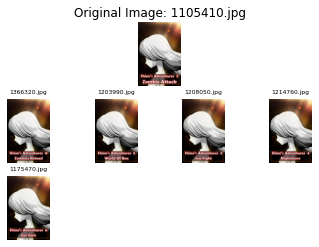

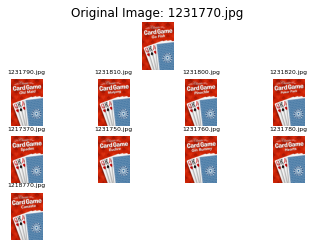

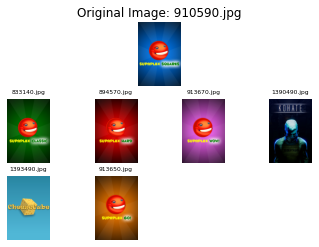

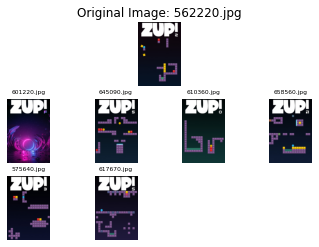

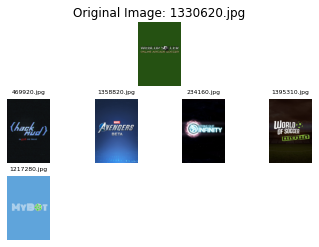

In [32]:
visualize_duplicates(image_dir_hr,
                     hr_duplicates,
                     hr_duplicates_all,
                     hr_duplicates_to_remove,
                     threshold_for_display = 4)

#### Low-resolution images (256x256)

In [20]:
encodings_lr = encoder.encode_images(image_dir=image_dir_lr)

2020-11-29 09:19:39,565: INFO Start: Calculating hashes...
100%|██████████| 17492/17492 [00:35<00:00, 498.78it/s]
2020-11-29 09:20:14,716: INFO End: Calculating hashes!


In [33]:
lr_duplicates, lr_duplicates_all, lr_duplicates_to_remove = get_duplicates(encodings_lr,
                                                                           max_distance_threshold = 10)

2020-11-29 09:24:24,096: INFO Start: Evaluating hamming distances for getting duplicates
2020-11-29 09:24:24,097: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 17492/17492 [00:01<00:00, 11097.12it/s]
2020-11-29 09:24:25,821: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-11-29 09:24:25,822: INFO End: Evaluating hamming distances for getting duplicates
2020-11-29 09:24:25,833: INFO Start: Evaluating hamming distances for getting duplicates
2020-11-29 09:24:25,833: INFO Start: Retrieving duplicates using Cython Brute force algorithm


#duplicates = 617


100%|██████████| 17492/17492 [00:01<00:00, 11604.08it/s]
2020-11-29 09:24:27,416: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-11-29 09:24:27,417: INFO End: Evaluating hamming distances for getting duplicates


#duplicates to remove = 313


/usr/local/lib/python3.6/dist-packages/imagededup/utils/plotter.py:66: UserWarning: tight_layout: falling back to Agg renderer
  gs.tight_layout(fig)


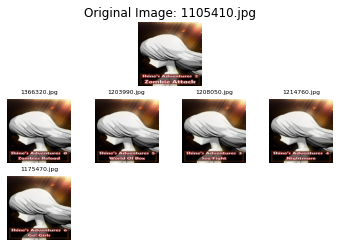

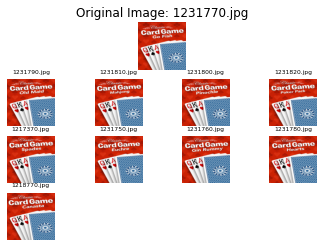

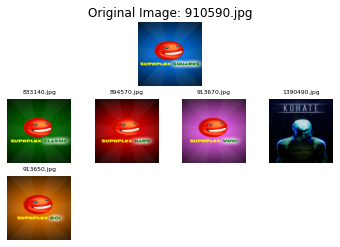

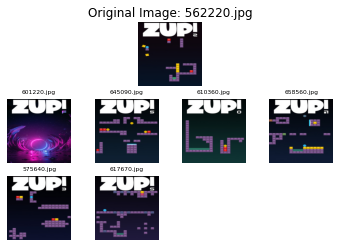

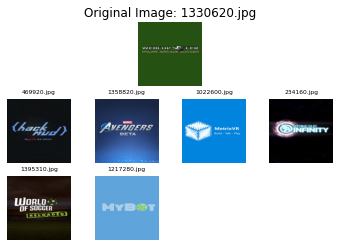

In [34]:
visualize_duplicates(image_dir_lr,
                     lr_duplicates,
                     lr_duplicates_all,
                     lr_duplicates_to_remove,
                     threshold_for_display = 4)

#### Merge

In [35]:
duplicates_all = set(hr_duplicates_all).union(lr_duplicates_all)
print('#duplicates = {}'.format(len(duplicates_all)))

#duplicates = 652


### Compare with pre-computed

In [48]:
allowed_app_ids = []
previously_missed_duplicates = []

for f_name in duplicates_all:
  app_id = get_app_id(f_name)

  # Duplicates missed at high-resolution (banners, logos), and detected here!
  if app_id not in previously_known_duplicates:
    previously_missed_duplicates.append(app_id)

  # Duplicates which I would have allowed, in the following "strict" setting:
  # - filter both banners AND logos at high-resolution,
  # - then remove ALL duplicates
  if app_id in app_ids_strict:
    allowed_app_ids.append(app_id)

print('#duplicates missed before = {}'.format(len(previously_missed_duplicates)))
print('#duplicates allowed in strict setting = {}'.format(len(allowed_app_ids)))

set_intersection = set(previously_missed_duplicates).intersection(allowed_app_ids)
print('cardinal of set intersection = {}'.format(len(set_intersection)))

#duplicates missed before = 529
#duplicates allowed in strict setting = 481
cardinal of set intersection = 481


/usr/local/lib/python3.6/dist-packages/imagededup/utils/plotter.py:66: UserWarning: tight_layout: falling back to Agg renderer
  gs.tight_layout(fig)


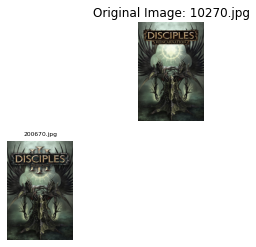

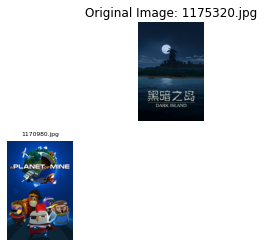

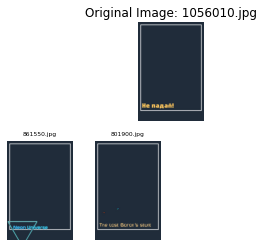

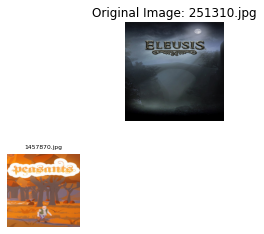

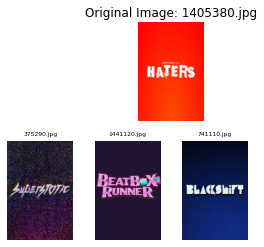

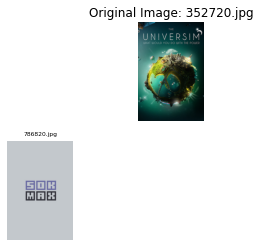

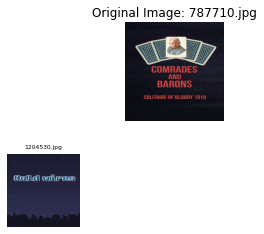

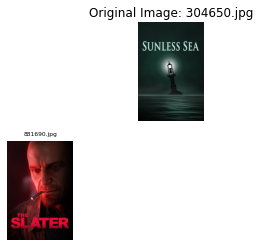

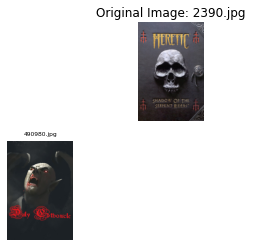

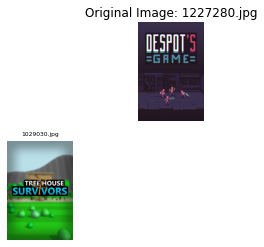

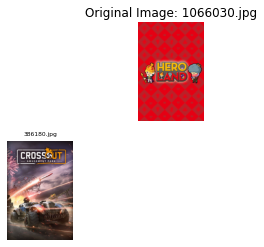

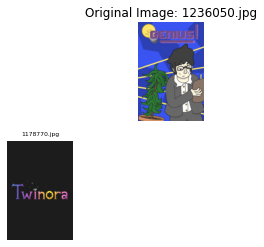

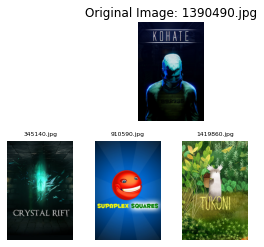

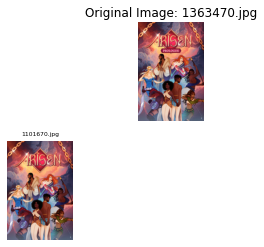

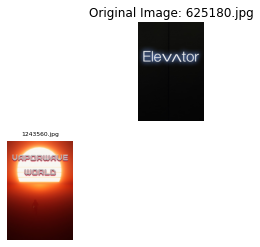

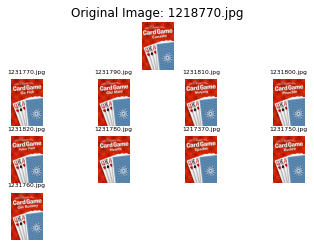

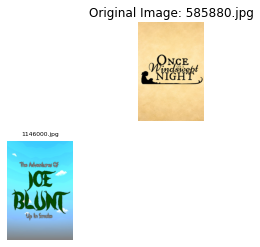

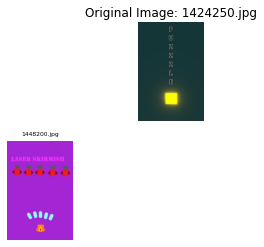

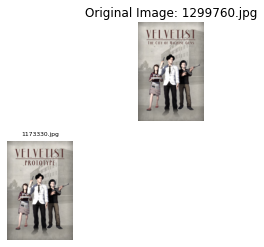

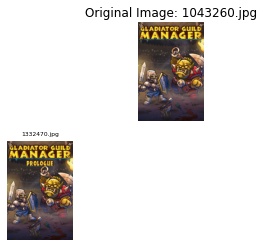

In [52]:
max_display = 20

for counter, app_id in enumerate(previously_missed_duplicates, start=1):
  if counter > max_display:
    break

  fname = str(app_id)+'.jpg'

  if fname in hr_duplicates_all:
    plot_duplicates(image_dir=image_dir_hr,
                    duplicate_map=hr_duplicates,
                    filename=fname)
  else:
    plot_duplicates(image_dir=image_dir_lr,
                    duplicate_map=lr_duplicates,
                    filename=fname)

## Face detection

Reference: https://github.com/woctezuma/steam-face-detection

### Pre-computed

-   on both high-resolution images and low-resolution images.

0 -> steam-face-detection/data/app_ids_with_faces_with_dlib.json
DescribeResult(nobs=2236, minmax=(1, 13), mean=1.3689624329159213, variance=0.7134702428833847, skewness=3.8033381433319877, kurtosis=25.167827544396967)


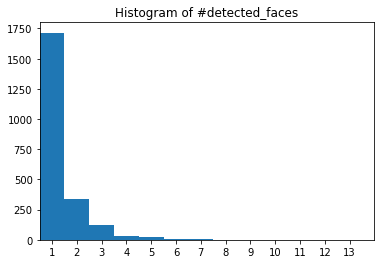

#images = 1715 (77%) with #faces/image = 1
#other_images = 521
----------------------------------------------------------------------
1 -> steam-face-detection/data/app_ids_with_faces_with_dlib_resized.json
DescribeResult(nobs=561, minmax=(1, 4), mean=1.1319073083778965, variance=0.16471224853577793, skewness=3.534921413280134, kurtosis=14.304872468930121)


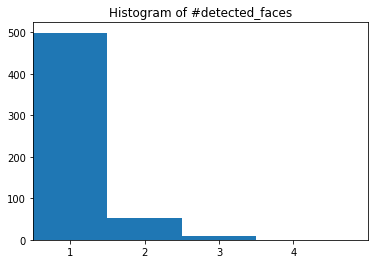

#images = 499 (89%) with #faces/image = 1
#other_images = 62
----------------------------------------------------------------------
2 -> steam-face-detection/data/app_ids_with_faces_with_fa.json
DescribeResult(nobs=4392, minmax=(1, 41), mean=1.5259562841530054, variance=1.531551123572434, skewness=10.492076909652882, kurtosis=261.9617800552161)


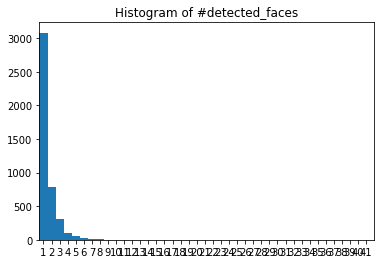

#images = 3083 (70%) with #faces/image = 1
#other_images = 1309
----------------------------------------------------------------------
3 -> steam-face-detection/data/app_ids_with_faces_with_fa_resized.json
DescribeResult(nobs=2732, minmax=(1, 15), mean=1.3444363103953147, variance=0.7143483822475316, skewness=4.521189517595076, kurtosis=37.337939545892795)


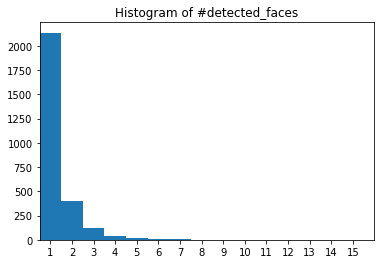

#images = 2136 (78%) with #faces/image = 1
#other_images = 596
----------------------------------------------------------------------
4 -> steam-face-detection/data/refined_app_ids_with_faces_with_fa.json
DescribeResult(nobs=3836, minmax=(1, 36), mean=1.8717413972888426, variance=2.4482129771749963, skewness=5.240957893692891, kurtosis=71.83677302180803)


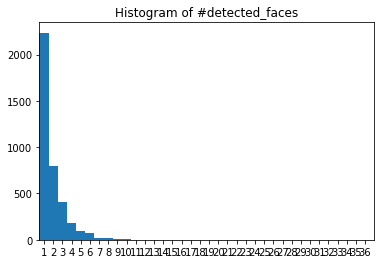

#images = 2236 (58%) with #faces/image = 1
#other_images = 1600
----------------------------------------------------------------------
5 -> steam-face-detection/data/refined_app_ids_with_faces_with_fa_resized.json
DescribeResult(nobs=2388, minmax=(1, 19), mean=1.6850921273031825, variance=1.5874274318106383, skewness=3.435135214428428, kurtosis=22.637940752184257)


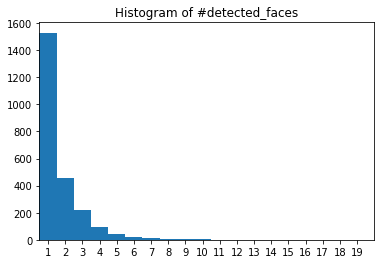

#images = 1529 (64%) with #faces/image = 1
#other_images = 859
----------------------------------------------------------------------


In [54]:
import glob
import json

fnames = glob.glob('steam-face-detection/data/*.json')
fnames.sort()
for i, fname in enumerate(fnames):
  print('{} -> {}'.format(i, fname))
  
  with open(fname, 'r') as f:
    app_id_dict = json.load(f)

  data_for_faces = [ i for i in app_id_dict.values() ]

  analyze_data(data_for_faces)
  print('-'*70)

### From scratch

In [ ]:
# Recommended value: False (to avoid running unnecessary computations)
refine_with_landmarks = False

# Recommended value: True (to copy face_alignment's internal process)
use_BGR = True

#### High-resolution images (300x450)

In [ ]:
from collections import Counter

image_dir = 'data/original_vertical_steam_banners'

print('Directory: {}'.format(image_dir))
file_names = list_file_names(image_dir=image_dir)
app_id_dict = process_image_batch_with_fa(file_names,
                                          refine_with_landmarks=refine_with_landmarks,
                                          use_BGR=use_BGR)
save_app_id_dict_with_fa(app_id_dict,
                         image_dir,
                         refine_with_landmarks=refine_with_landmarks,
                         use_BGR=use_BGR)

Loading refined_app_ids_with_faces_with_fa.json
Counter({1: 3085, 2: 785, 3: 312, 4: 103, 5: 53, 6: 30, 7: 9, 8: 9, 10: 3, 20: 2, 41: 1, 9: 1})
DescribeResult(nobs=4393, minmax=(1, 41), mean=1.5258365581607103, variance=1.5339976208216664, skewness=10.473393549530497, kurtosis=261.09591567161647)


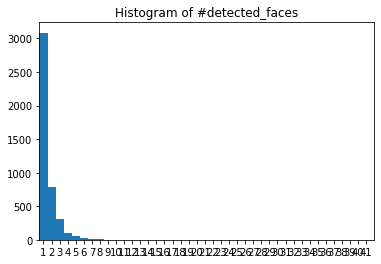

#images = 3085 (70%) with #faces/image = 1
#other_images = 1308


In [89]:
image_dir = 'data/original_vertical_steam_banners'
app_id_dict_hr = load_app_id_dict_with_fa(image_dir,
                                          refine_with_landmarks=refine_with_landmarks,
                                          use_BGR=use_BGR)

counter = Counter(app_id_dict_hr.values())
print(counter)

data_for_faces = [ i for i in app_id_dict_hr.values() ]
analyze_data(data_for_faces)

#### Low-resolution images (256x256)

In [ ]:
from collections import Counter

image_dir = 'data/resized_vertical_steam_banners'

print('Directory: {}'.format(image_dir))
file_names = list_file_names(image_dir=image_dir)
app_id_dict = process_image_batch_with_fa(file_names,
                                          refine_with_landmarks=refine_with_landmarks,
                                          use_BGR=use_BGR)
save_app_id_dict_with_fa(app_id_dict,
                         image_dir,
                         refine_with_landmarks=refine_with_landmarks,
                         use_BGR=use_BGR)

Loading refined_app_ids_with_faces_with_fa_resized.json
Counter({1: 2139, 2: 399, 3: 122, 4: 39, 5: 15, 6: 10, 7: 7, 8: 2, 15: 1})
DescribeResult(nobs=2734, minmax=(1, 15), mean=1.343818580833943, variance=0.7137982195448568, skewness=4.525053098603649, kurtosis=37.38370020666417)


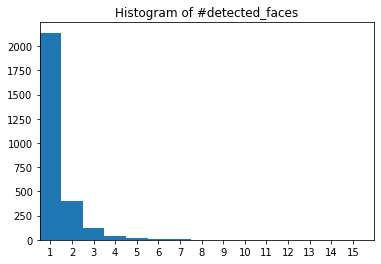

#images = 2139 (78%) with #faces/image = 1
#other_images = 595


In [90]:
image_dir = 'data/resized_vertical_steam_banners'
app_id_dict_lr = load_app_id_dict_with_fa(image_dir,
                                          refine_with_landmarks=refine_with_landmarks,
                                          use_BGR=use_BGR)

counter = Counter(app_id_dict_lr.values())
print(counter)

data_for_faces = [ i for i in app_id_dict_lr.values() ]
analyze_data(data_for_faces)

#### Merge

Counter({1: 1428, 2: 199, 3: 75, 4: 19, 5: 11, 7: 3, 6: 2})
DescribeResult(nobs=1737, minmax=(1, 7), mean=1.2751871042026481, variance=0.5025694494188561, skewness=3.4893016672841823, kurtosis=15.508347647664174)


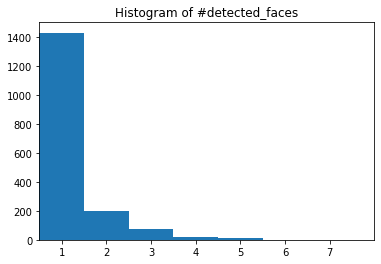

#images = 1428 (82%) with #faces/image = 1
#other_images = 309


In [100]:
common_app_ids = set(app_id_dict_hr).intersection(app_id_dict_lr)

app_id_dict = dict()
for app_id in common_app_ids:
  m = app_id_dict_hr[app_id]
  n = app_id_dict_lr[app_id]
  if m == n:
    app_id_dict[app_id] = m

counter = Counter(app_id_dict.values())
print(counter)

data_for_faces = [ i for i in app_id_dict.values() ]
analyze_data(data_for_faces)    

Done.

## Combination

### Pre-computed

#### Display stats

In [106]:
import glob
import json

for i, fname in enumerate(fnames):
  print('{} -> {}'.format(i, fname))

  with open(fname, 'r') as f:
    d = json.load(f)

  filtered_app_ids = get_combination(app_ids_strict,
                                     duplicates_all,
                                     app_id_dict=d,
                                     max_num_faces = 1)
  print('-'*70)

0 -> steam-face-detection/data/app_ids_with_faces_with_dlib.json
Strict: 16231

To keep: 1715
#appIDs = 1610

To remove: 652
#appIDs = 1569
----------------------------------------------------------------------
1 -> steam-face-detection/data/app_ids_with_faces_with_dlib_resized.json
Strict: 16231

To keep: 499
#appIDs = 461

To remove: 652
#appIDs = 447
----------------------------------------------------------------------
2 -> steam-face-detection/data/app_ids_with_faces_with_fa.json
Strict: 16231

To keep: 3083
#appIDs = 2907

To remove: 652
#appIDs = 2842
----------------------------------------------------------------------
3 -> steam-face-detection/data/app_ids_with_faces_with_fa_resized.json
Strict: 16231

To keep: 2136
#appIDs = 2011

To remove: 652
#appIDs = 1963
----------------------------------------------------------------------
4 -> steam-face-detection/data/refined_app_ids_with_faces_with_fa.json
Strict: 16231

To keep: 2236
#appIDs = 2096

To remove: 652
#appIDs = 2044
-

#### Combine

2 -> steam-face-detection/data/app_ids_with_faces_with_fa.json
3 -> steam-face-detection/data/app_ids_with_faces_with_fa_resized.json
4 -> steam-face-detection/data/refined_app_ids_with_faces_with_fa.json
5 -> steam-face-detection/data/refined_app_ids_with_faces_with_fa_resized.json
DescribeResult(nobs=2210, minmax=(1, 20), mean=2.107239819004525, variance=2.590124111768189, skewness=2.53803336694234, kurtosis=11.734787644458764)


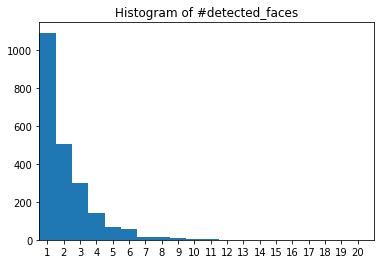

#images = 1090 (49%) with #faces/image = 1
#other_images = 1120
Strict: 16231

To keep: 1090
#appIDs = 1025

To remove: 652
#appIDs = 996


In [108]:
import glob
import json

# selected_indices = range(len(fnames))
selected_indices = [2,3,4,5]
# selected_indices = [2,3]
# selected_indices = [4,5]

d_combined = None

for i, fname in enumerate(fnames):
  if i not in selected_indices:
    continue

  print('{} -> {}'.format(i, fname))

  with open(fname, 'r') as f:
    d = json.load(f)

  if d_combined is None:
    d_combined = dict(d)
  else:
    temp = list(d_combined.keys())
    for i in temp:
      if i in d:
        d_combined[i] = max(d_combined[i], d[i])
      else:
        d_combined.pop(i)        

data_for_faces = [ i for i in d_combined.values() ]

analyze_data(data_for_faces)

filtered_app_ids = get_combination(app_ids_strict,
                                    duplicates_all,
                                    app_id_dict=d_combined,
                                    max_num_faces = 1)

### From scratch

In [109]:
filtered_app_ids = get_combination(app_ids_strict,
                                    duplicates_all,
                                    app_id_dict=app_id_dict,
                                    max_num_faces = 1)

Strict: 16231

To keep: 1428
#appIDs = 1344

To remove: 652
#appIDs = 1311


### Export

In [117]:
from pathlib import Path

def get_input_folder(resolution='hr'):
  if resolution == 'hr':
    input_folder = image_dir_hr
  else:
    input_folder = image_dir_lr

  return input_folder

def get_output_folder(resolution='hr'):
  output_folder = 'steam-oneface-{}/'.format(resolution)
  Path(output_folder).mkdir(exist_ok=True)

  return output_folder

def get_output_archive(resolution='hr'):
  output_folder = get_output_folder(resolution)
  archive_name = output_folder.strip('/') + '.tar.gz'

  return archive_name

In [118]:
import shutil

for resolution in ['hr', 'lr']:
  input_folder = get_input_folder(resolution)
  output_folder = get_output_folder(resolution)

  for app_id in filtered_app_ids:
    fname = str(app_id) + '.jpg'
    shutil.copyfile(input_folder + fname, 
                    output_folder + fname)

In [119]:
for resolution in ['hr', 'lr']:
  output_folder = get_output_folder(resolution)
  archive_name = get_output_archive(resolution)
  
  !du -sh {output_folder}
  !tar -cf {archive_name} {output_folder}
  !du -sh {archive_name}

74M	steam-oneface-hr/
73M	steam-oneface-hr.tar.gz
42M	steam-oneface-lr/
40M	steam-oneface-lr.tar.gz


In [121]:
import colab_transfer

gd = colab_transfer.get_path_to_home_of_google_drive()
lm = colab_transfer.get_path_to_home_of_local_machine()

colab_transfer.mount_google_drive()

Mounted at /content/drive/


In [122]:
for resolution in ['hr', 'lr']:
  output_folder = get_output_folder(resolution)
  archive_name = get_output_archive(resolution)

  colab_transfer.copy_file(file_name=archive_name,
                           source = lm,
                           destination = gd)

Copying /content/steam-oneface-hr.tar.gz to /content/drive/My Drive/steam-oneface-hr.tar.gz
Copying /content/steam-oneface-lr.tar.gz to /content/drive/My Drive/steam-oneface-lr.tar.gz


Done.